In [1]:
import torch
from torch.utils.data import DataLoader

from inpainting import transforms
from inpainting.load import MergeDataset, SequenceDataset
from inpainting.utils import dilate_mask, annotation_to_mask, tensor_to_pil_image, get_paths

In [2]:
images_dataset = SequenceDataset(
    get_paths(f'../data/interim/DAVIS/JPEGImages/480p/tennis'),
    'image',
    sequence_length=1,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)
masks_dataset = SequenceDataset(
    get_paths(f'../data/interim/DAVIS/Annotations/480p/tennis'),
    'annotation',
    sequence_length=1,
    transform=transforms.Compose([
        transforms.Lambda(lambda x: annotation_to_mask(x, object_id=[1, 2])),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: dilate_mask(x, 3, 3))
    ])
)
dataset = MergeDataset([images_dataset, masks_dataset])
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [3]:
images, masks = next(iter(data_loader))
image, mask = images[0].cuda(), masks[0].cuda()

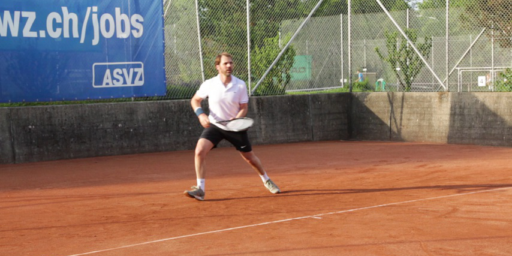

In [4]:
tensor_to_pil_image(image)

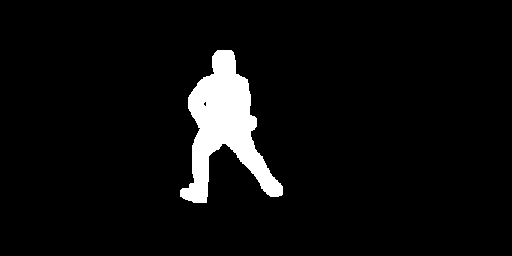

In [5]:
tensor_to_pil_image(mask)

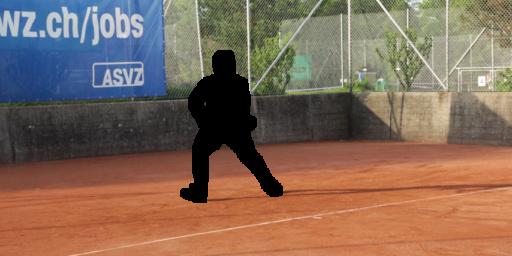

In [6]:
tensor_to_pil_image(image * (1 - mask))

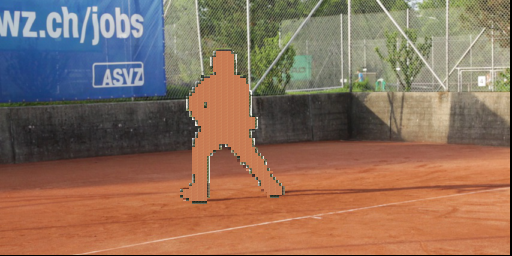

In [35]:
patch_size = 3
overlap = 1

# for i in tqdm(list(range(1000))):
patches = torch.nn.functional.unfold(
    image * (1 - mask),
    kernel_size=[patch_size, patch_size],
    stride=[patch_size // overlap, patch_size // overlap]
).squeeze(0)
mask_patches = torch.nn.functional.unfold(
    1 - mask,
    kernel_size=[patch_size, patch_size],
    stride=[patch_size // overlap, patch_size // overlap]
).squeeze(0)

query = patches.permute(1, 0)
key = patches
value = patches

eps = 1e-8
query_norm = torch.norm(query, dim=1).unsqueeze(1) + eps
key_norm = torch.norm(key, dim=0).unsqueeze(0) + eps
attention = torch.matmul(query, key) / torch.matmul(query_norm, key_norm)

a = torch.sum(mask_patches, dim=0)
b = (a == torch.max(a)).float().unsqueeze(0)
attention = attention * b

values, indices = torch.max(attention, dim=1)

out = value[:, indices]

result = torch.nn.functional.fold(
    out.unsqueeze(0),
    output_size=image.size()[2:],
    kernel_size=[patch_size, patch_size],
    stride=[patch_size // overlap, patch_size // overlap]
)
tensor_to_pil_image(result)
